In [38]:
import pandas as pd
import numpy as array_lib
import scipy
import plotly.express as px

In [2]:
indir="/Users/allenma/forAREA/Neuroblastoma/cangelosi_neuroblastoma/"
boolfile = indir+"NB_boolean.csv"
rankablefile = indir+"NB_rankfile.csv"


In [3]:
bool_df = pd.read_csv(boolfile, index_col=0)
rank_df =pd.read_csv(rankablefile, index_col=0)

In [4]:
print(bool_df.columns)

Index(['above18', 'below18', 'didnotsurvived', 'survived', 'stage_4',
       'stage_3', 'stage_2', 'stage_1', 'stage_4s', 'myc_amplified',
       'myc_notamplified', 'hypoxia_favorable', 'hypoxia_unfavorable',
       'rnaseq', 'agilent4x44k', 'hgu133plus2', 'Participant'],
      dtype='object')


In [5]:
print(rank_df.columns)

Index(['A1BG', 'A2M', 'A4GNT', 'AAAS', 'AACS', 'AADAC', 'AADAT', 'AAED1',
       'AAGAB', 'AAK1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDC', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'Participant'],
      dtype='object', length=13697)


In [147]:
def calculateNESpval(actualES, simES,use_gpu):
    '''Calculate NES and p-value'''
    #sys.stdout = open('mylog.log', 'a')
    if actualES > 0:
            print("actualES > 0", actualES)
            simESsubset = array_lib.array([x for x in simES if x < 0])
            mu = array_lib.mean(simESsubset)  # Use array_lib mean
            NES = actualES / mu
            sigma = array_lib.std(simESsubset)  # Use array_lib std
            if use_gpu:
                actualES_np = actualES.get()
                mu_np = mu.get()
                sigma_np = sigma.get()
            else:
                actualES_np = actualES
                mu_np = mu
                sigma_np = sigma
            p = 1 - scipy.stats.norm.cdf(actualES_np, mu_np, sigma_np)
    else:
            simESsubset = array_lib.array([x for x in simES if x > 0])
            mu = array_lib.mean(simESsubset)  # Use array_lib mean
            NES = -(actualES / mu)
            sigma = array_lib.std(simESsubset)  # Use array_lib std
            if use_gpu:
                actualES_np = actualES.get()
                mu_np = mu.get()
                sigma_np = sigma.get()
            else:
                actualES_np = actualES
                mu_np = mu
                sigma_np = sigma
            p = scipy.stats.norm.cdf(actualES_np, mu_np, sigma_np)
    return NES, p


def run_a_ba(ba,valuecols, outdir, commoncolumn, rankorderdf, badf, keepsamples,use_gpu):
    bacols_common = [ba, commoncolumn]
    valuecols_common = valuecols+[commoncolumn]
    subbadf = badf[bacols_common]
    subrankorderdf = rankorderdf[valuecols_common]
    mergedf = subbadf.merge(subrankorderdf, on=commoncolumn, how="inner")
    if len(keepsamples)>1:
        mergedf = mergedf[mergedf[commoncolumn].isin(keepsamples)]
    df = mergedf.sample(frac=1).reset_index(drop=True) #Randomizes the order of the merged datafame before we sort on rank value so 0 are in diff order each time
    thiscomorbidity_binary = df[ba].to_list()
    simES_norm = permute_area_norm(thiscomorbidity_binary, permutations=1000)
    lines = []
    for colname in valuecols:
        df = df.sort_values(colname)
        fig_df = df.copy()
        fig_df["rank"] = array_lib.arange(len(df))
        fig_df = fig_df[fig_df[ba]==1]
        fig_df["size"] = fig_df[ba]/100
        fig = px.density_heatmap(fig_df,x="rank", y=ba, labels={"rank": "Sample rank lowest to highest", ba:"Number with "+ba},nbinsx=10)
        fig.show()
        thiscomorbidity_binary = df[ba].to_list()
        actualES_norm, normalized_pc_score_norm, thistrend_norm, thiscumscore_norm = area_score_norm(thiscomorbidity_binary)
        # Column-bind (each array as a column)
        stacked = array_lib.column_stack([thistrend_norm, thiscumscore_norm])
        columns = ['trend', 'cumscore']
        fig_df = pd.DataFrame(stacked, columns=columns)
        fig_df['rank'] = array_lib.arange(len(df))
        df_long = fig_df.melt(id_vars=['rank'], 
                  value_vars=['trend', 'cumscore'], 
                  var_name='measurement', value_name='value')
        fig = px.scatter(df_long, x="rank", y="value", color="measurement", labels={"rank": "Sample rank lowest to highest", "value":"Enrichment of "+ba})
        fig.show()
        onegeneNES, onegenepval = calculateNESpval(actualES_norm, simES_norm,use_gpu)
        line = [colname, onegeneNES, onegenepval]
        lines.append(line)
    baNESpvals = pd.DataFrame(lines, columns = ["ranked_by","NES", "pval"])
    baNESpvals["boolean_attribute"]=ba
    baNESpvals = baNESpvals[["boolean_attribute", "ranked_by","NES", "pval"]]
    return baNESpvals

def permute_area_norm(ar_ticks, permutations=1000, seed=42):
    '''Generates permutations of the ranks and calculates AUC for each
        permutation.'''

    array_lib.random.seed(seed=seed)
    ar_ticks = array_lib.array(ar_ticks)
    es_permute = []
    for i in range(permutations):
        random_ar_score = array_lib.random.permutation(ar_ticks)  # Array_lib permutation
        es_permute_score = area_score_norm(random_ar_score)  # Use area_score_norm
        es_permute.append(es_permute_score[0])

    return es_permute

def area_score_norm(ar_ticks, verbose=False):
    '''Calculate the GSEA like enrichment score using the comorbidity
    occurance in the rank as our set'''
    #sys.stdout = open('mylog.log', 'a')
    ar_score = array_lib.array([1 if i > 0 else 0 for i in ar_ticks])  # Use array_lib (either cp or array_lib)
    total = float(array_lib.sum(ar_score))  # Use array_lib sum

    binwidth = 1.0 / float(len(ar_score))
    normalized_ar_score = array_lib.multiply(array_lib.divide(ar_score, total), binwidth)  # Normalization with array_lib

    cumscore = array_lib.cumsum(normalized_ar_score)  # Cumulative sum with array_lib
    trend = array_lib.append(array_lib.arange(0, 1, 1.0 / float(len(cumscore) - 1)), 1.0)
    trend = array_lib.multiply(trend, binwidth)  # Multiplying trend by binwidth

    actual_es = (array_lib.trapz(cumscore) - array_lib.trapz(trend)) * 2

    if verbose:
        print("Binwidth                        :"+str(binwidth))
        print("Sum of normalized binary scores :"+str(array_lib.sum(normalized_ar_score)))
        print("Sum cumulative score            :"+str(array_lib.sum(cumscore)))
        print("Sum of trend                    :"+str(array_lib.sum(trend)))
        print("Len of trend                    :"+str(len(trend)))
        print("Actual Area                     :"+str(actual_es))

    return [actual_es, normalized_ar_score, trend, cumscore]

In [148]:
ba="survived"
badf = bool_df[["Participant", "survived", "didnotsurvived"]]
rankorderdf = rank_df[["Participant", "MYCN"]]
outdir ="/Users/allenma/forAREA/Neuroblastoma/cangelosi_neuroblastoma/"
use_gpu = False
keepsamples = rankorderdf["Participant"].to_list()
commoncolumn = "Participant"
valuecols = [cn for cn in rankorderdf if cn!=commoncolumn]

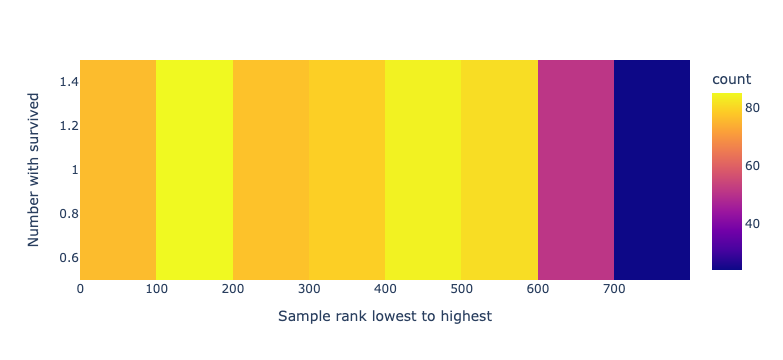

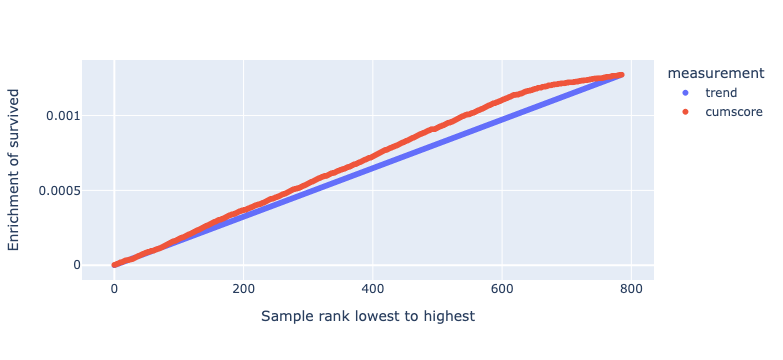

actualES > 0 0.1050589079081421


,boolean_attribute,ranked_by,NES,pval
0,survived,MYCN,-10.428395,0.0


In [149]:
run_a_ba(ba,valuecols, outdir, commoncolumn, rankorderdf, badf, keepsamples,use_gpu)

In [150]:
ba="didnotsurvived"
badf = bool_df[["Participant", "survived", "didnotsurvived"]]
rankorderdf = rank_df[["Participant", "MYCN"]]
outdir ="/Users/allenma/forAREA/Neuroblastoma/cangelosi_neuroblastoma/"
use_gpu = False
keepsamples = rankorderdf["Participant"].to_list()
commoncolumn = "Participant"
valuecols = [cn for cn in rankorderdf if cn!=commoncolumn]

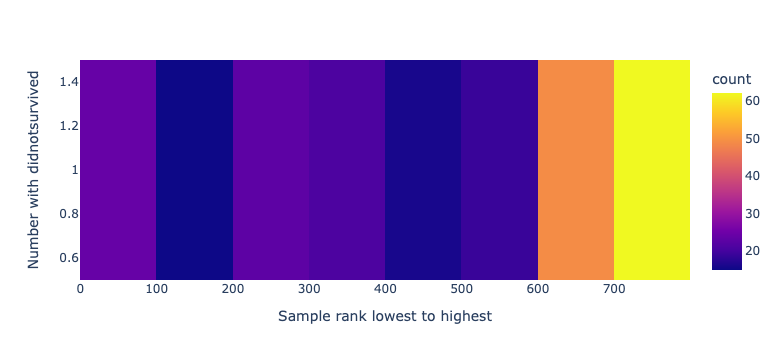

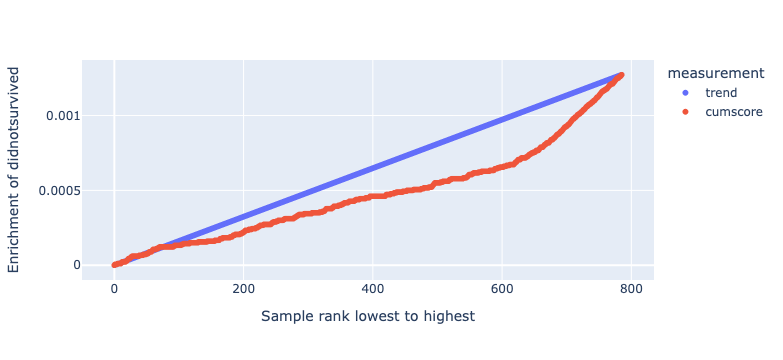

,boolean_attribute,ranked_by,NES,pval
0,didnotsurvived,MYCN,9.412463,2.802609e-48


In [151]:
run_a_ba(ba,valuecols, outdir, commoncolumn, rankorderdf, badf, keepsamples,use_gpu)